# Select a nice subset of data and remove NaNs

In [1]:
from pathlib import Path
import shutil
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rc("figure", dpi=100)

In [12]:
np.random.seed(0)

In [3]:
data_dir = Path("../data/raw/")
out_dir = Path("../data/temperature/")
out_dir.mkdir(exist_ok=True, parents=True)

In [4]:
data_files = sorted(data_dir.glob("*.txt"))
print(len(data_files))

233


In [5]:
data = {}
for data_file in data_files:
    with open(data_file, encoding="latin1") as file_pointer:
        for line in file_pointer:
            if "Estimated Jan 1951-Dec 1980 absolute temperature (C):" in line:
                components = line.split(":")[1].split("+/-")
                assert len(components) == 2
                absolute_temperature = float(components[0])
                break
        else:
            raise ValueError(f"Abolute temperature not found for {data_file}")
        year, month, anomaly = np.loadtxt(
            file_pointer, 
            comments="%",
            usecols=[0, 1, 4],
            unpack=True,
        )
        temperature = anomaly + absolute_temperature
        time = year + 1 / 12 * (month - 1)
        data[data_file.name[:-4]] = (time, temperature, anomaly)

In [6]:
data_recent = {}
start_year = 1940
#data_since_start = 12 * (2021 - start_year) - 6
for country in data:
    time, temperature, anomaly = data[country]
    recent = (time >= start_year)
    # Last 6 months are absent because of the 1-year average
    recent[-6:] = False
    if not np.any(np.isnan(temperature[recent])):
        data_recent[country] = (time[recent], temperature[recent], anomaly[recent])
print(len(data_recent))

227


In [7]:
uk_time = data_recent["united-kingdom"][0]
for country in list(data_recent.keys()):
    time = data_recent[country][0]
    if time.shape != uk_time.shape or not np.allclose(uk_time, time):
        data_recent.pop(country)
print(len(data_recent))

176


In [8]:
selected_countries = sorted([
    "brazil", 
    "philippines", 
    "japan", 
    "haiti", 
    "france", 
    "zimbabwe", 
    "mongolia", 
    "ethiopia", 
    "oman", 
    "united-kingdom",
])
assert set(data_recent).issuperset(selected_countries), f"Invalid countries: {set(selected_countries).difference(data_recent)}"

In [9]:
ndata = [data_recent[c][2][~np.isnan(data_recent[c][2])].size for c in selected_countries]
ndata

[966, 966, 966, 966, 966, 966, 966, 966, 966, 966]

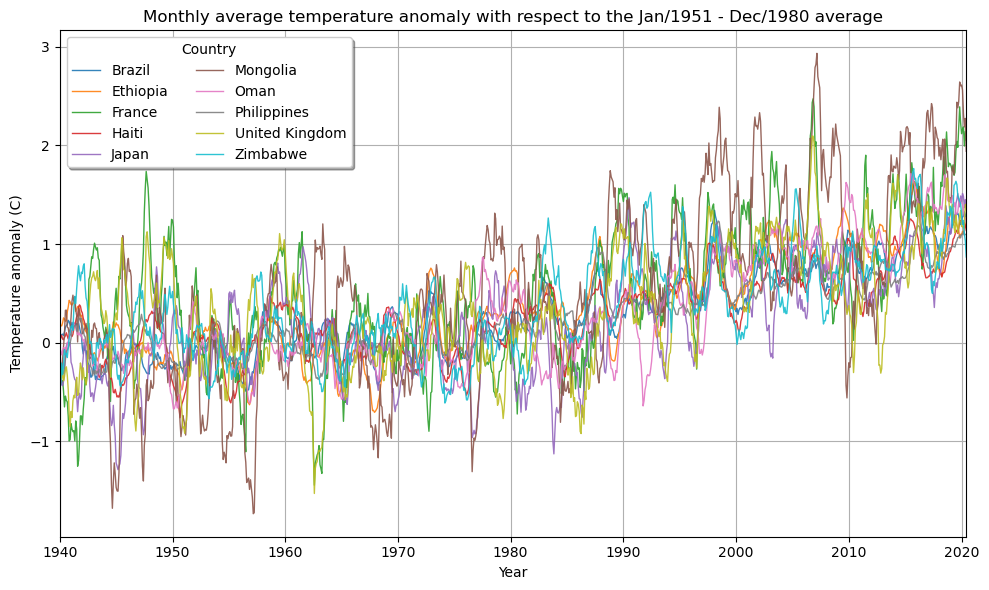

In [9]:
plt.figure(figsize=(10, 6))
for country in selected_countries:
    time, temperature, anomaly = data_recent[country]    
    plt.plot(
        time, 
        anomaly, 
        label=country.replace("-", " ").title(),
        linewidth=1,
        alpha=0.9,
    )
plt.xlim(time.min(), time.max())
plt.grid()
plt.xlabel("Year")
plt.ylabel("Temperature anomaly (C)")
plt.legend(ncol=2, shadow=True, title="Country", markerscale=10)
plt.title("Monthly average temperature anomaly with respect to the Jan/1951 - Dec/1980 average")
plt.tight_layout()
plt.savefig("temperature-anomaly-countries.png", pad_inches=0, facecolor="white")

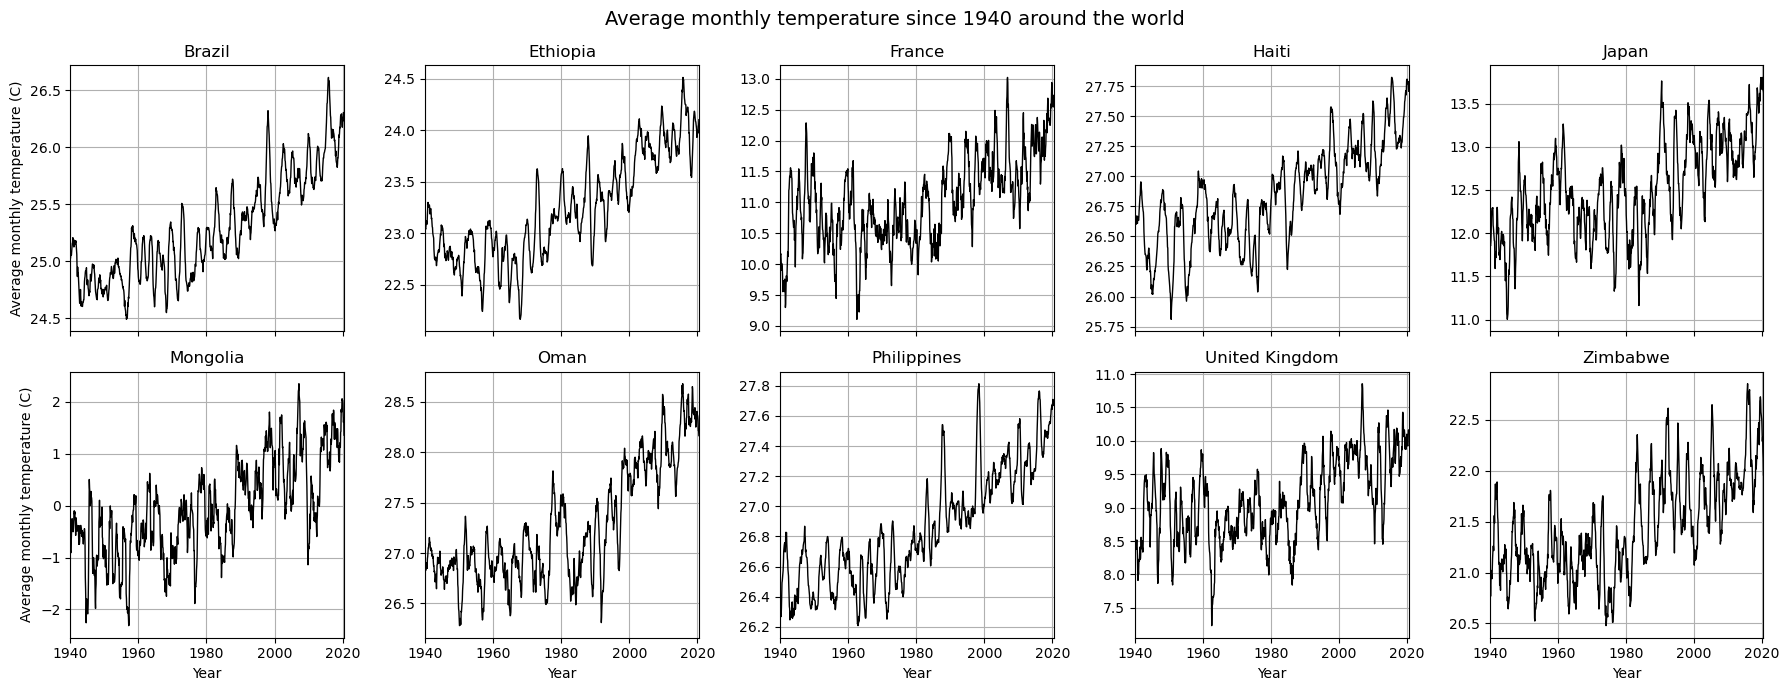

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(18, 7), sharex=True)
fig.suptitle(f"Average monthly temperature since {start_year} around the world", size=14)
for country, ax in zip(selected_countries, axes.ravel()):
    time, temperature, anomaly = data_recent[country]
    ax.set_title(country.replace("-", " ").title())
    ax.plot(time, temperature, "-k", linewidth=1)
    ax.set_xlim(time.min(), time.max())
    ax.grid()
for ax in axes[1, :]:
    ax.set_xlabel("Year")
for ax in axes[:, 0]:
    ax.set_ylabel("Average monthly temperature (C)")    
fig.tight_layout()
fig.savefig("temperature-countries.png", pad_inches=0, facecolor="white")

In [11]:
for country in selected_countries:
    np.savetxt(
        out_dir / f"{country}.csv",
        np.transpose(data_recent[country]),
        delimiter=",",
        fmt="%.3f",
    )

In [12]:
country_list = "\n".join([f"* {name.replace('-', ' ').title()}" for name in selected_countries])
readme = f"""
Monthly average temperature
---------------------------

This archive contains monthly average temperature records
since {start_year} for the following countries:

{country_list}

The data for each country is contained in a CSV file with 
columns: time, temperature (C), and temperature anomaly (C)

The temperature anomaly is calculated with respect to the 
average temperature between Jan/1951 and Dec/1980.

The data are a subset of the original data files from
Berkeley Earth (http://berkeleyearth.lbl.gov).
""".strip()

(out_dir / "README.txt").write_text(readme)

print(readme)

Monthly average temperature
---------------------------

This archive contains monthly average temperature records
since 1940 for the following countries:

* Brazil
* Ethiopia
* France
* Haiti
* Japan
* Mongolia
* Oman
* Philippines
* United Kingdom
* Zimbabwe

The data for each country is contained in a CSV file with 
columns: time, temperature (C), and temperature anomaly (C)

The temperature anomaly is calculated with respect to the 
average temperature between Jan/1951 and Dec/1980.

The data are a subset of the original data files from
Berkeley Earth (http://berkeleyearth.lbl.gov).


In [13]:
_ = shutil.make_archive(
    base_name=str(out_dir), 
    format="zip", 
    base_dir=out_dir.parts[-1], 
    root_dir=out_dir.parent
)

In [37]:
more_countries = sorted(np.random.choice(list(data_recent.keys()), size=65, replace=False))
assert set(data_recent).issuperset(more_countries), f"Invalid countries: {set(more_countries).difference(data_recent)}"

In [38]:
ndata = [data_recent[c][2][~np.isnan(data_recent[c][2])].size for c in more_countries]
np.all(np.equal(ndata[0], ndata))

True

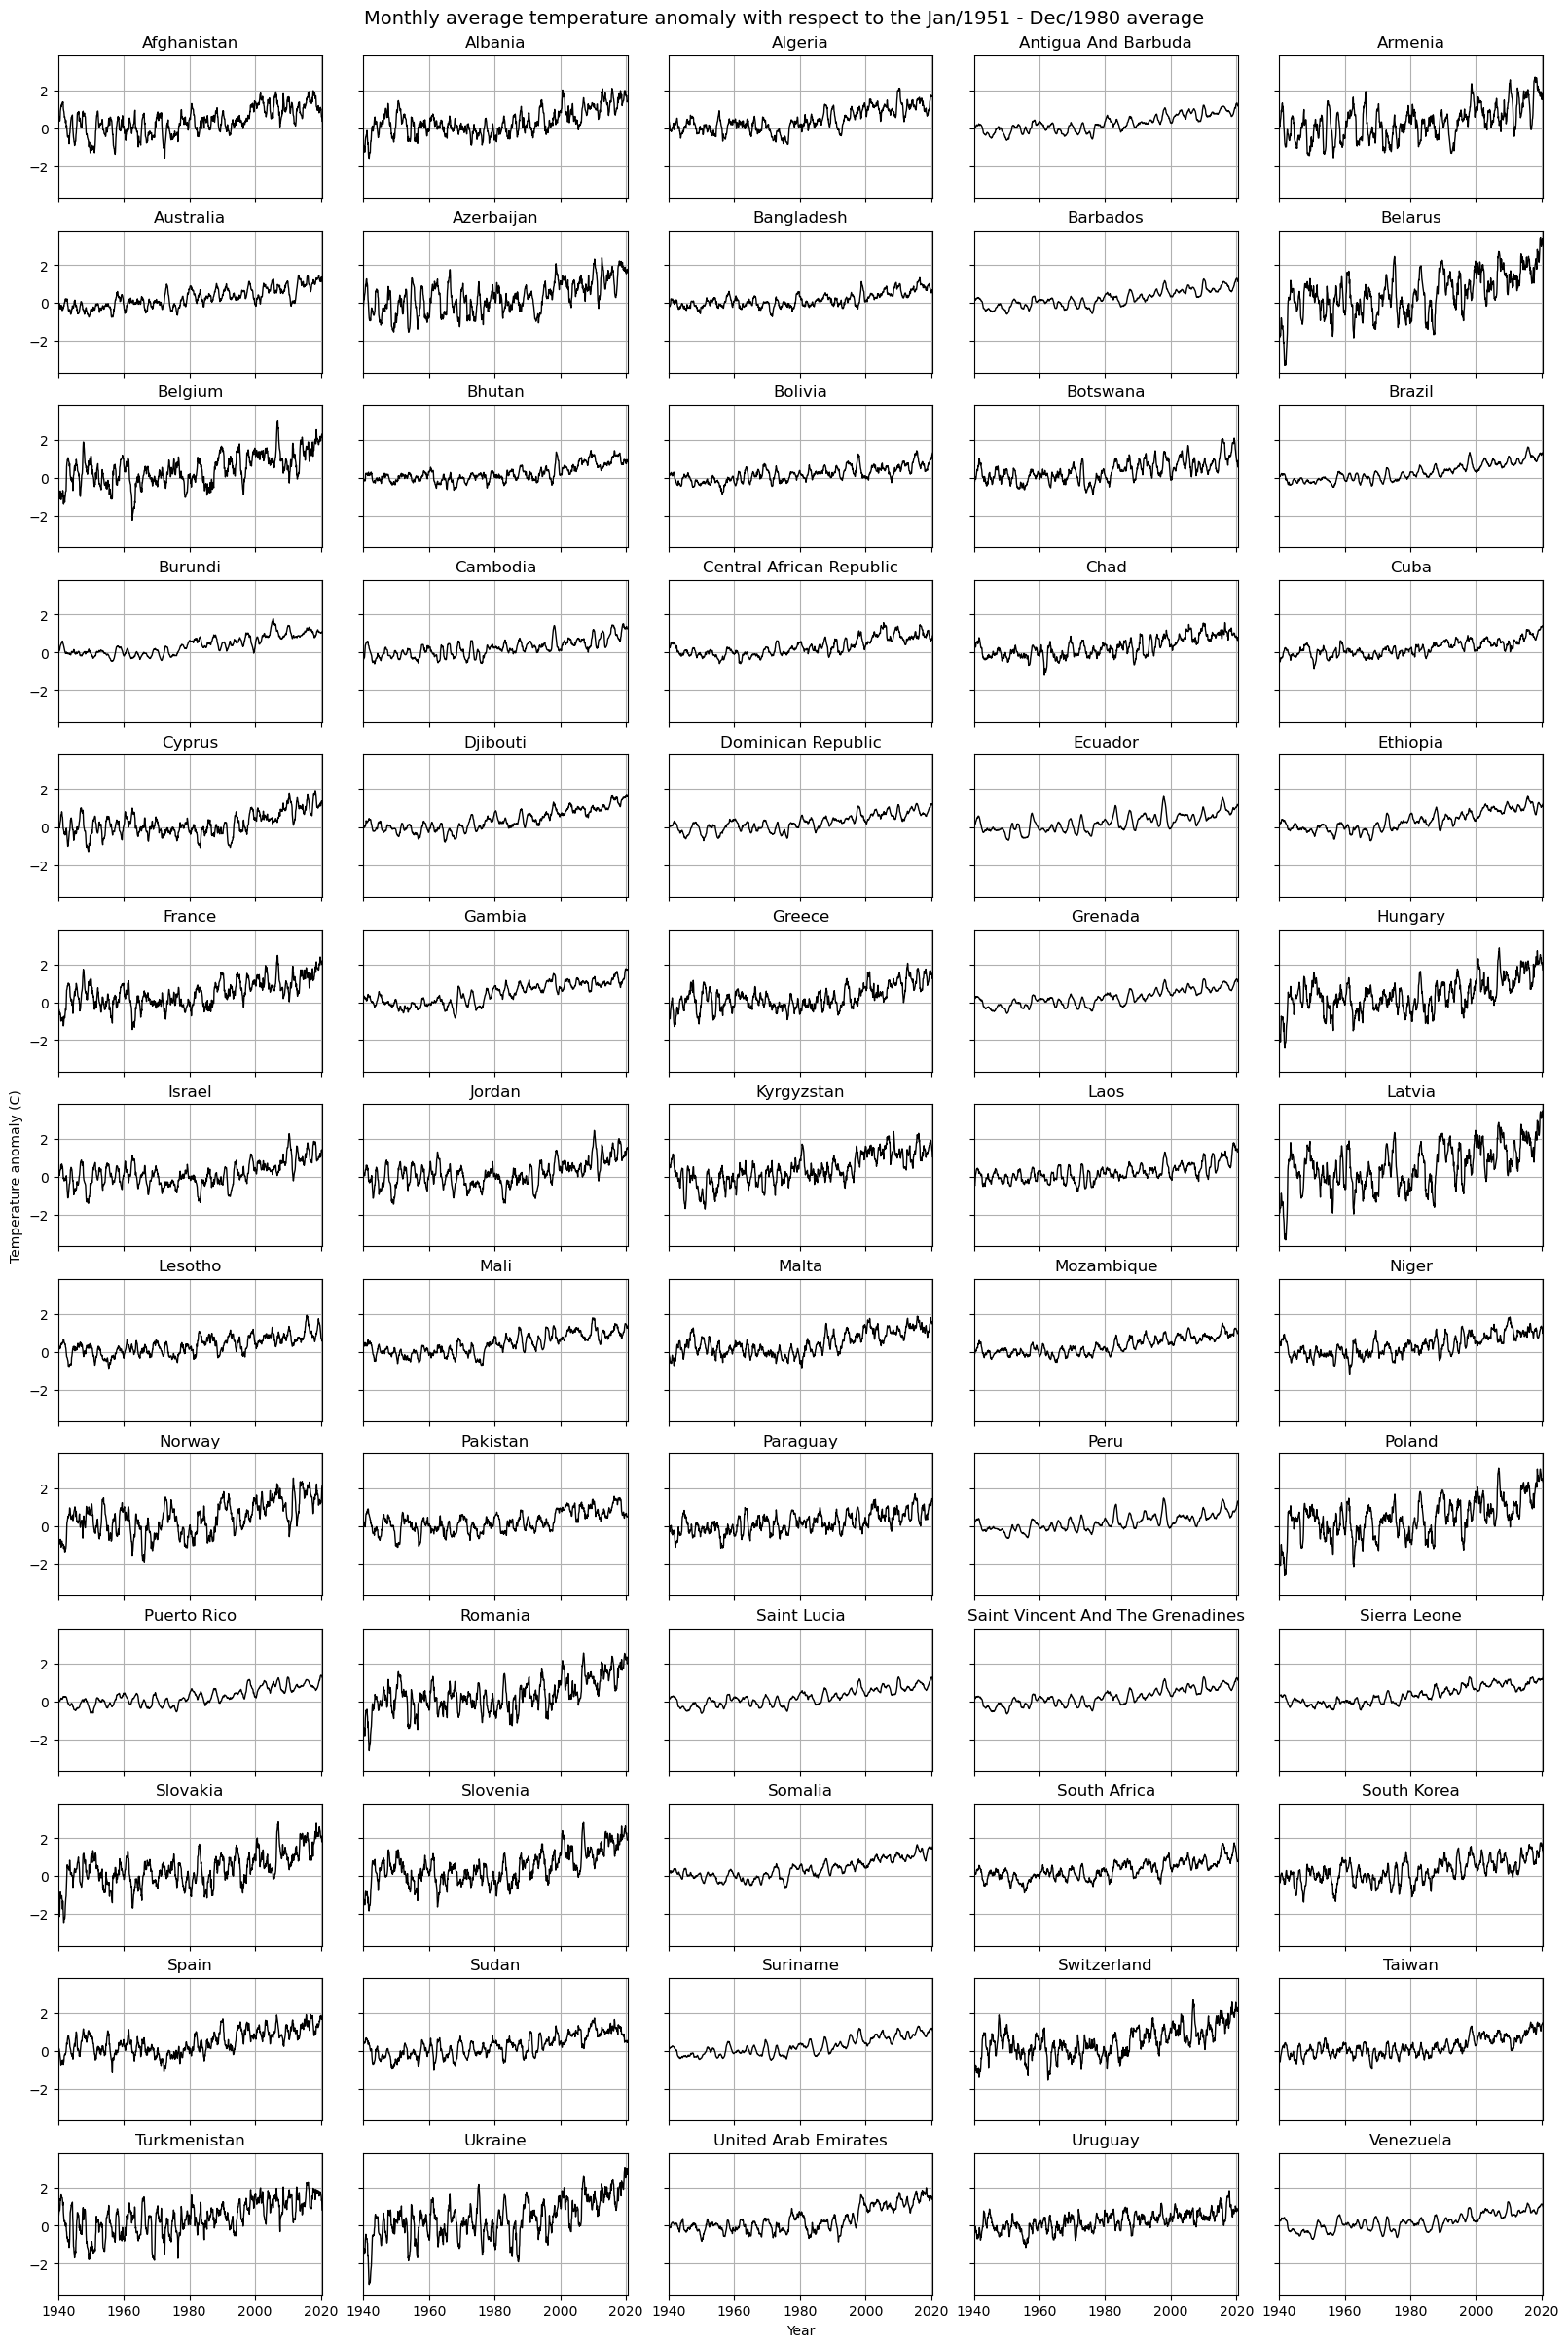

In [42]:
fig, axes = plt.subplots(13, 5, figsize=(16, 24), sharex=True, sharey=True, constrained_layout=True)
fig.suptitle("Monthly average temperature anomaly with respect to the Jan/1951 - Dec/1980 average", size=14)
for country, ax in zip(more_countries, axes.ravel()):
    time, temperature, anomaly = data_recent[country]
    ax.set_title(country.replace("-", " ").title())
    ax.plot(time, anomaly, "-k", linewidth=1)
    ax.set_xlim(time.min(), time.max())
    ax.grid()
ax = axes[-1, axes.shape[1]//2]
ax.set_xlabel("Year")
ax = axes[axes.shape[0]//2, 0]
ax.set_ylabel("Temperature anomaly (C)")
fig.savefig("temperature-countries-more.png", pad_inches=0, facecolor="white")

In [43]:
out_dir = Path("../data/temperature-more/")
out_dir.mkdir(exist_ok=True, parents=True)

In [48]:
for country in more_countries:
    np.savetxt(
        out_dir / f"{country}.csv",
        np.transpose(data_recent[country]),
        delimiter=",",
        fmt="%.3f",
    )

In [49]:
country_list = "\n".join([f"* {name.replace('-', ' ').title()}" for name in more_countries])
readme = f"""
Monthly average temperature
---------------------------

This archive contains monthly average temperature records
since {start_year} for the following {len(more_countries)} countries:

{country_list}

The data for each country is contained in a CSV file with 
columns: time, temperature (C), and temperature anomaly (C)

The temperature anomaly is calculated with respect to the 
average temperature between Jan/1951 and Dec/1980.

The data are a subset of the original data files from
Berkeley Earth (http://berkeleyearth.lbl.gov).
""".strip()

(out_dir / "README.txt").write_text(readme)

print(readme)

Monthly average temperature
---------------------------

This archive contains monthly average temperature records
since 1940 for the following 65 countries:

* Afghanistan
* Albania
* Algeria
* Antigua And Barbuda
* Armenia
* Australia
* Azerbaijan
* Bangladesh
* Barbados
* Belarus
* Belgium
* Bhutan
* Bolivia
* Botswana
* Brazil
* Burundi
* Cambodia
* Central African Republic
* Chad
* Cuba
* Cyprus
* Djibouti
* Dominican Republic
* Ecuador
* Ethiopia
* France
* Gambia
* Greece
* Grenada
* Hungary
* Israel
* Jordan
* Kyrgyzstan
* Laos
* Latvia
* Lesotho
* Mali
* Malta
* Mozambique
* Niger
* Norway
* Pakistan
* Paraguay
* Peru
* Poland
* Puerto Rico
* Romania
* Saint Lucia
* Saint Vincent And The Grenadines
* Sierra Leone
* Slovakia
* Slovenia
* Somalia
* South Africa
* South Korea
* Spain
* Sudan
* Suriname
* Switzerland
* Taiwan
* Turkmenistan
* Ukraine
* United Arab Emirates
* Uruguay
* Venezuela

The data for each country is contained in a CSV file with 
columns: time, temperature 

In [50]:
_ = shutil.make_archive(
    base_name=str(out_dir), 
    format="zip", 
    base_dir=out_dir.parts[-1], 
    root_dir=out_dir.parent
)